In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
pathname = "data"
print("[INFO] loading images...")
imagePaths = list(paths.list_images(pathname))
data = []
labels = []


[INFO] loading images...


In [4]:
import h5py
from PIL import Image

for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]

	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)
	labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

C:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

9420800/9406464 [==============================] - 45s 5us/step


In [7]:
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


C:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
188/188 [==============================] - 355s 2s/step - loss: 0.2600 - accuracy: 0.9176 - val_loss: 0.0843 - val_accuracy: 0.9801
Epoch 2/20
188/188 [==============================] - 263s 1s/step - loss: 0.0863 - accuracy: 0.9757
Epoch 3/20
188/188 [==============================] - 243s 1s/step - loss: 0.0634 - accuracy: 0.9822
Epoch 4/20
188/188 [==============================] - 211s 1s/step - loss: 0.0488 - accuracy: 0.9864
Epoch 5/20
188/188 [==============================] - 208s 1s/step - loss: 0.0476 - accuracy: 0.9854
Epoch 6/20
188/188 [==============================] - 210s 1s/step - loss: 0.0445 - accuracy: 0.9869
Epoch 7/20
188/188 [==============================] - 209s 1s/step - loss: 0.0430 - accuracy: 0.9869
Epoch 8/20
188/188 [==============================] - 208s 1s/step - loss: 0.0390 - accuracy: 0.9875
Epoch 9/20
188/188 [==============================] - 345s 2s/step - loss: 0.0337 - accuracy: 0.9884
Epoch 10/20
188/188 [====

In [15]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       745
without_mask       1.00      0.98      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511

[INFO] saving mask detector model...


C:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


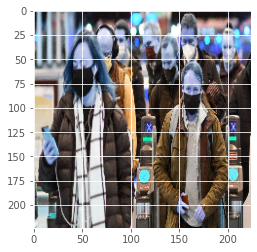

In [16]:
import cv2 
sample_mask_img = cv2.imread('a.jpg')
sample_mask_img = cv2.resize(sample_mask_img,(224,224))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,224,224,3])
sample_mask_img = sample_mask_img/255.0

In [17]:
model.predict(sample_mask_img)

array([[9.9999964e-01, 3.4405716e-07]], dtype=float32)

In [18]:
model.save('masknet.h5')

In [19]:
mask_label = {
    0:'MASK',
    1:'NO MASK'
             }
rect_label = {
    0:(0,250,0),
    1:(250,0,0)
             }

In [20]:
def show_results(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

    label = [0 for i in range(len(faces))]
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    counter_masks = {
        'has_mask': 0,
        'no_mask': 0
    }
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]

        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0

        mask_result = model.predict(crop)
        has_mask = mask_result.argmax()

        if has_mask==0:
            counter_masks['has_mask'] += 1
        else:
            counter_masks['no_mask'] += 1

        cv2.putText(new_img,mask_label[has_mask],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,rect_label[has_mask],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),rect_label[has_mask],1)

    plt.figure(figsize=(10,10))
    annot1 = f"People with MASKS: {counter_masks['has_mask']};"
    annot2 = f"People with NO MASKS: {counter_masks['no_mask']}."
    cv2.putText(new_img,text=annot1,org=(10, 10),fontFace=cv2.FONT_HERSHEY_TRIPLEX,fontScale=0.5,color=(255, 255, 255),thickness=1)
    cv2.putText(new_img,text=annot2,org=(10, 30),fontFace=cv2.FONT_HERSHEY_TRIPLEX,fontScale=0.5,color=(255, 255, 255),thickness=1)
    plt.imshow(new_img)

In [21]:
import random
import glob

In [22]:
good_preds = [
    'a.jpg','b.jpg','c.jpg','d.jpg',
]

for p in good_preds:
    print(p)
    show_results(p)

a.jpg


NameError: name 'face_model' is not defined